# Lunds Variables Pair Plot Analysis

This notebook analyzes Lunds variables from a parquet file and creates visualizations including:
- Pair plots of key Lunds variables
- Correlation matrix heatmap
- Data summary statistics

The Lunds variables represent jet substructure observables that are useful for understanding the internal structure of jets in high-energy particle physics.

## Import Required Libraries

Import pandas, numpy, seaborn, matplotlib, and pathlib for data handling and visualization.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from pathlib import Path

# Set matplotlib backend for inline plotting
%matplotlib inline

# Set seaborn style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

## Load Lunds Data from Parquet File

Define and use a function to load Lunds data from a parquet file, flatten the nested structure, and return a DataFrame.

In [2]:
def load_lunds_data(parquet_file):
    """
    Load lunds data from parquet file and extract variables for pair plot
    """
    # Read the parquet file
    df = pd.read_parquet(parquet_file)
    
    # Extract all lunds data into a flat DataFrame
    all_lunds = []
    
    for idx, row in df.iterrows():
        lunds = row['lunds']
        for lund in lunds:
            # Add jet-level information to each lund entry
            lund_entry = lund.copy()
            lund_entry['jet_pt'] = row['pt']
            lund_entry['jet_eta'] = row['eta']
            lund_entry['jet_phi'] = row['phi']
            lund_entry['jet_m'] = row['m']
            lund_entry['label'] = row['label']
            all_lunds.append(lund_entry)
    
    return pd.DataFrame(all_lunds)

# Define the parquet file path
parquet_file = "/Users/ploskon/devel/alian/alian/sandbox/jse/sample_lundjet_1000/lund_jet_hardQCDgluons.parquet"

# Check if file exists
if not Path(parquet_file).exists():
    print(f"Error: File {parquet_file} not found!")
else:
    print("Loading lunds data from parquet file...")
    lunds_df = load_lunds_data(parquet_file)
    print(f"Successfully loaded {len(lunds_df)} lund splittings")

Loading lunds data from parquet file...
Successfully loaded 11183 lund splittings


## Print Data Summary

Print summary statistics of the Lunds data, including counts and variable ranges.

In [3]:
def print_data_summary(lunds_df):
    """
    Print summary statistics of the lunds data
    """
    print("Lunds Data Summary:")
    print(f"Total number of lund splittings: {len(lunds_df)}")
    print(f"Number of jets: {lunds_df['jet_pt'].nunique() if 'jet_pt' in lunds_df.columns else 'Unknown'}")
    
    if 'label' in lunds_df.columns:
        print(f"Labels distribution:")
        print(lunds_df['label'].value_counts().sort_index())
    
    print(f"\nVariable ranges:")
    key_vars = ['delta', 'eta', 'kappa', 'kt', 'm', 'pt', 'z']
    for var in key_vars:
        if var in lunds_df.columns:
            print(f"  {var}: [{lunds_df[var].min():.3e}, {lunds_df[var].max():.3e}]")

# Print data summary
print_data_summary(lunds_df)

Lunds Data Summary:
Total number of lund splittings: 11183
Number of jets: 1114
Labels distribution:
label
2    11183
Name: count, dtype: int64

Variable ranges:
  delta: [3.699e-04, 4.305e-01]
  eta: [-2.125e+00, 2.091e+00]
  kappa: [9.437e-06, 1.834e-01]
  kt: [5.482e-04, 2.177e+01]
  m: [2.342e-03, 3.317e+01]
  pt: [3.993e+00, 1.200e+02]
  z: [7.951e-05, 5.000e-01]


## Create Pair Plot of Lunds Variables

Generate a seaborn pair plot for selected Lunds variables, applying log transforms where appropriate and using hue for labels if available.

Creating pair plot...
Pair plot saved to: lunds_pairplot.png
Pair plot saved to: lunds_pairplot.png


<Figure size 1200x1000 with 0 Axes>

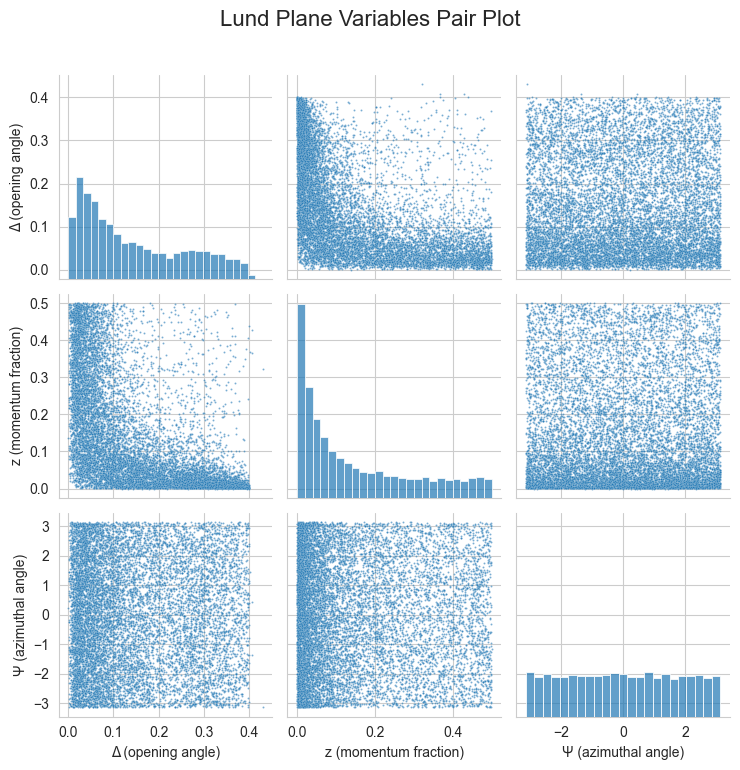

In [7]:
def create_lunds_pairplot(lunds_df, output_file='lunds_pairplot.png'):
    """
    Create seaborn pair plot for lunds variables
    """
    # Select key variables for the pair plot
    # These are the most physically meaningful variables from the lunds splitting
    key_vars = ['delta', 'eta', 'kappa', 'kt', 'm', 'pt', 'z', 'psi']
    
    # Filter the dataframe to only include these variables
    plot_df = lunds_df[key_vars + ['label']].copy()
    
    # Remove any infinite or NaN values
    plot_df = plot_df.replace([np.inf, -np.inf], np.nan).dropna()
    
    # Apply log scale to some variables that have wide dynamic range
    plot_df['log_kt'] = np.log10(plot_df['kt'] + 1e-10)  # Add small constant to avoid log(0)
    plot_df['log_kappa'] = np.log10(plot_df['kappa'] + 1e-10)
    
    # Select final variables for plotting
    # final_vars = ['delta', 'eta', 'log_kappa', 'log_kt', 'm', 'pt', 'z', 'psi']
    final_vars = ['delta', 'z', 'psi']

    # Create the pair plot
    plt.figure(figsize=(12, 10))
    
    # Use hue to color by label if available
    if 'label' in plot_df.columns and plot_df['label'].nunique() > 1:
        g = sns.pairplot(plot_df[final_vars + ['label']], 
                        hue='label',
                        diag_kind='hist',
                        plot_kws={'alpha': 0.6, 's': 2},
                        diag_kws={'alpha': 0.7})
    else:
        g = sns.pairplot(plot_df[final_vars], 
                        diag_kind='hist',
                        plot_kws={'alpha': 0.6, 's': 2},
                        diag_kws={'alpha': 0.7})
    
    # Customize the plot
    g.fig.suptitle('Lund Plane Variables Pair Plot', y=1.02, fontsize=16)
    
    # Add variable descriptions as axis labels
    var_labels = {
        'delta': 'Δ (opening angle)',
        'eta': 'η (pseudorapidity)', 
        'log_kappa': 'log(κ)',
        'log_kt': 'log(kT)',
        'm': 'mass',
        'pt': 'pT',
        'z': 'z (momentum fraction)',
        'psi': 'Ψ (azimuthal angle)'
    }
    
    # Update axis labels
    for i, ax_row in enumerate(g.axes):
        for j, ax in enumerate(ax_row):
            if i == len(g.axes) - 1:  # Bottom row
                ax.set_xlabel(var_labels.get(final_vars[j], final_vars[j]))
            if j == 0:  # Left column
                ax.set_ylabel(var_labels.get(final_vars[i], final_vars[i]))
    
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"Pair plot saved to: {output_file}")
    
    return g

# Create the pair plot
print("Creating pair plot...")
g = create_lunds_pairplot(lunds_df)
plt.show()

## Create Correlation Matrix Plot

Compute and visualize the correlation matrix of the selected (and log-transformed) Lunds variables using seaborn's heatmap.

Creating correlation matrix...
Correlation matrix saved to: lunds_correlation_matrix.png


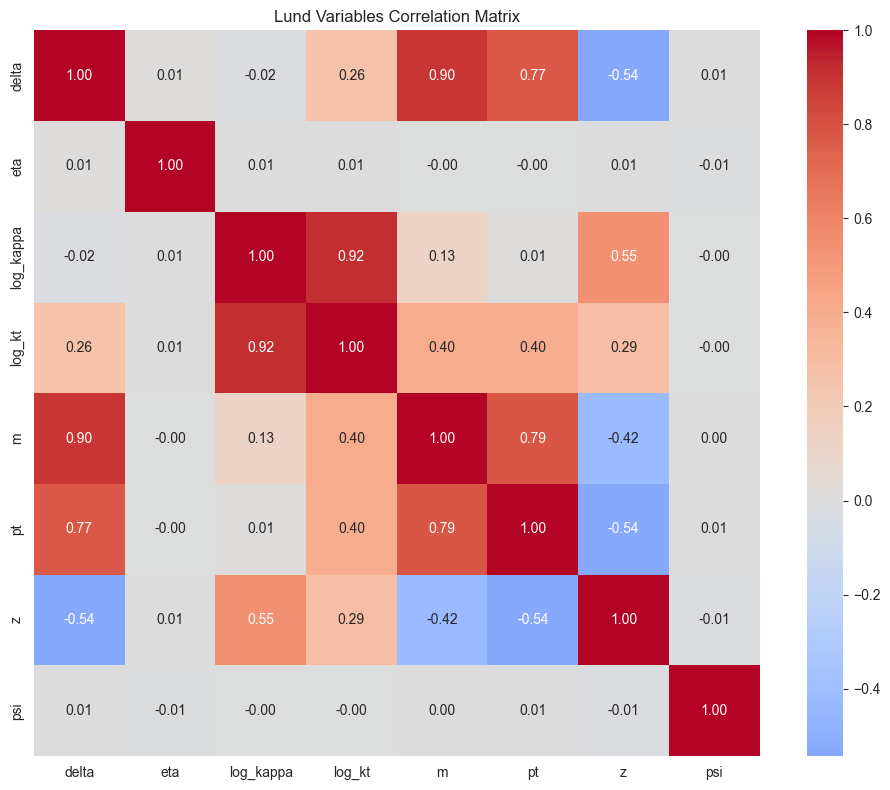

In [9]:
# Create correlation matrix plot
print("Creating correlation matrix...")

key_vars = ['delta', 'eta', 'kappa', 'kt', 'm', 'pt', 'z', 'psi']
corr_data = lunds_df[key_vars].copy()
corr_data['log_kt'] = np.log10(corr_data['kt'] + 1e-10)
corr_data['log_kappa'] = np.log10(corr_data['kappa'] + 1e-10)

plt.figure(figsize=(10, 8))
correlation_matrix = corr_data[['delta', 'eta', 'log_kappa', 'log_kt', 'm', 'pt', 'z', 'psi']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f')
plt.title('Lund Variables Correlation Matrix')
plt.tight_layout()
plt.savefig('lunds_correlation_matrix.png', dpi=300, bbox_inches='tight')
print("Correlation matrix saved to: lunds_correlation_matrix.png")
plt.show()

## Analyze Correlations in Subsequent Splittings

Investigate how variables in consecutive Lunds splittings are correlated within the same jet. This analysis looks at the relationship between splitting variables at different levels of the jet clustering hierarchy.

In [10]:
def analyze_subsequent_splitting_correlations(parquet_file):
    """
    Analyze correlations between consecutive splitting variables within the same jet
    """
    # Read the original parquet file to maintain jet structure
    df = pd.read_parquet(parquet_file)
    
    # Variables to analyze
    variables = ['delta', 'eta', 'kappa', 'kt', 'm', 'pt', 'z', 'psi']
    
    # Store correlations for each variable pair
    correlations = {}
    n_pairs = 0
    
    # Process each jet
    for idx, row in df.iterrows():
        lunds = row['lunds']
        
        # Need at least 2 splittings to compute correlations
        if len(lunds) < 2:
            continue
            
        # Compare consecutive splittings
        for i in range(len(lunds) - 1):
            current_split = lunds[i]
            next_split = lunds[i + 1]
            
            # Extract variables for both splittings
            for var in variables:
                if var in current_split and var in next_split:
                    key = f"{var}_correlation"
                    if key not in correlations:
                        correlations[key] = {'current': [], 'next': []}
                    
                    correlations[key]['current'].append(current_split[var])
                    correlations[key]['next'].append(next_split[var])
            
            n_pairs += 1
    
    print(f"Analyzed {n_pairs} pairs of consecutive splittings from {len(df)} jets")
    
    # Calculate correlation coefficients
    correlation_results = {}
    for var in variables:
        key = f"{var}_correlation"
        if key in correlations and len(correlations[key]['current']) > 1:
            current_vals = np.array(correlations[key]['current'])
            next_vals = np.array(correlations[key]['next'])
            
            # Remove infinite and NaN values
            mask = np.isfinite(current_vals) & np.isfinite(next_vals)
            if np.sum(mask) > 1:
                corr_coef = np.corrcoef(current_vals[mask], next_vals[mask])[0, 1]
                correlation_results[var] = {
                    'correlation': corr_coef,
                    'n_pairs': np.sum(mask),
                    'current_vals': current_vals[mask],
                    'next_vals': next_vals[mask]
                }
    
    return correlation_results

# Analyze subsequent splitting correlations
corr_results = analyze_subsequent_splitting_correlations(parquet_file)

# Display results
print("\nCorrelation between consecutive splittings:")
print("=" * 50)
for var, results in corr_results.items():
    print(f"{var:>8}: r = {results['correlation']:6.3f} (n = {results['n_pairs']:,})")

Analyzed 10069 pairs of consecutive splittings from 1114 jets

Correlation between consecutive splittings:
   delta: r =  0.959 (n = 10,069)
     eta: r =  1.000 (n = 10,069)
   kappa: r =  0.099 (n = 10,069)
      kt: r =  0.052 (n = 10,069)
       m: r =  0.927 (n = 10,069)
      pt: r =  0.950 (n = 10,069)
       z: r =  0.327 (n = 10,069)
     psi: r = -0.160 (n = 10,069)


Subsequent splitting correlations plot saved to: subsequent_splitting_correlations.png


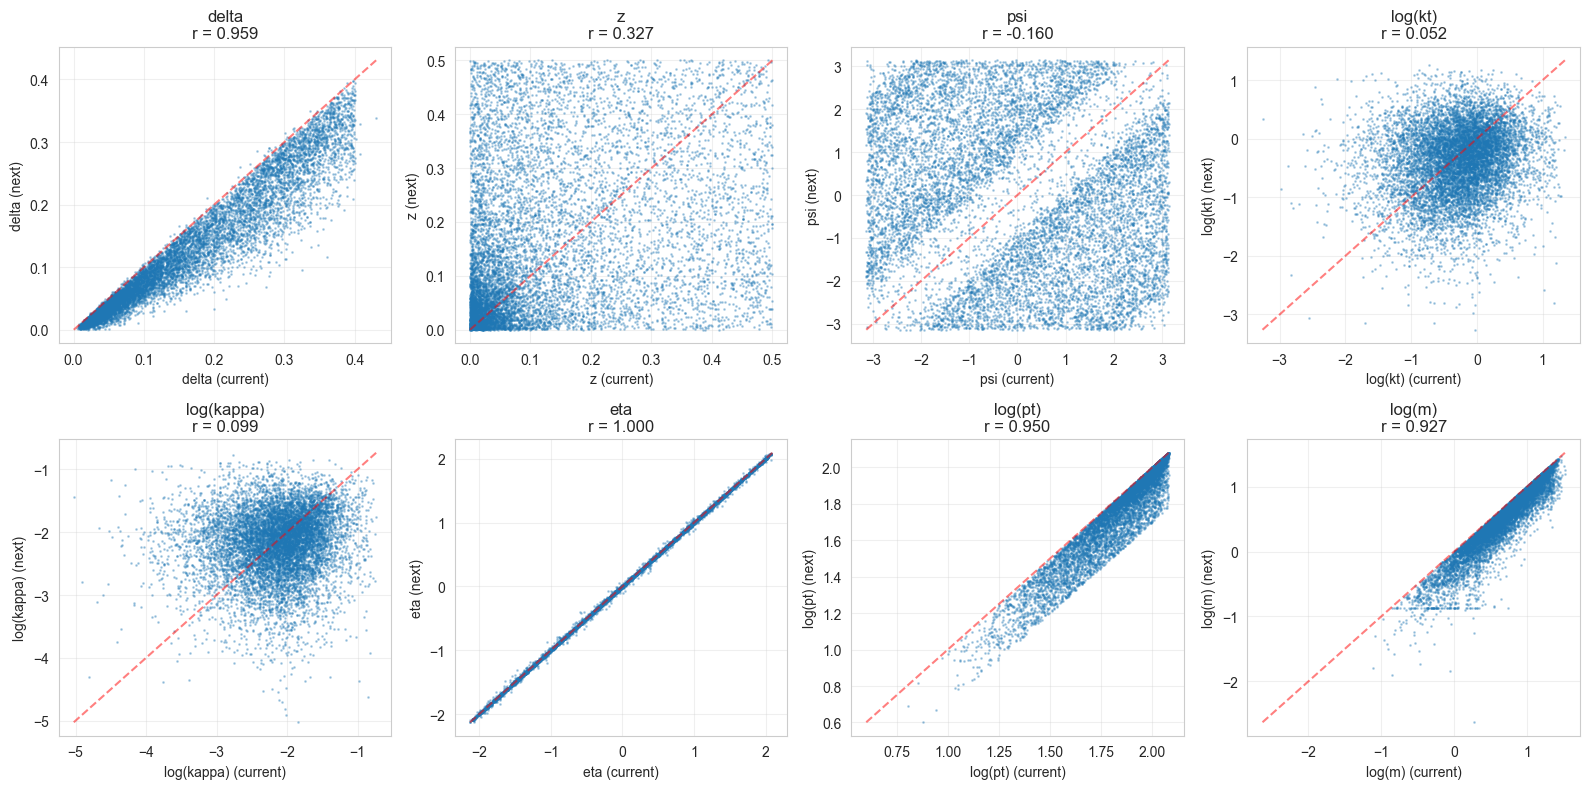

In [11]:
# Visualize correlations between subsequent splittings
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

plot_vars = ['delta', 'z', 'psi', 'kt', 'kappa', 'eta', 'pt', 'm']

for i, var in enumerate(plot_vars):
    if i < len(axes) and var in corr_results:
        ax = axes[i]
        current_vals = corr_results[var]['current_vals']
        next_vals = corr_results[var]['next_vals']
        
        # Apply log scale for variables with wide dynamic range
        if var in ['kt', 'kappa', 'pt', 'm']:
            current_vals = np.log10(current_vals + 1e-10)
            next_vals = np.log10(next_vals + 1e-10)
            var_label = f'log({var})'
        else:
            var_label = var
        
        # Create scatter plot
        ax.scatter(current_vals, next_vals, alpha=0.3, s=1)
        
        # Add correlation coefficient to plot
        r = corr_results[var]['correlation']
        ax.set_title(f'{var_label}\nr = {r:.3f}')
        ax.set_xlabel(f'{var_label} (current)')
        ax.set_ylabel(f'{var_label} (next)')
        
        # Add diagonal line for reference
        min_val = min(np.min(current_vals), np.min(next_vals))
        max_val = max(np.max(current_vals), np.max(next_vals))
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5)
        
        ax.grid(True, alpha=0.3)
    else:
        if i < len(axes):
            axes[i].set_visible(False)

plt.tight_layout()
plt.savefig('subsequent_splitting_correlations.png', dpi=300, bbox_inches='tight')
print("Subsequent splitting correlations plot saved to: subsequent_splitting_correlations.png")
plt.show()

Splitting depth correlations plot saved to: splitting_depth_correlations.png


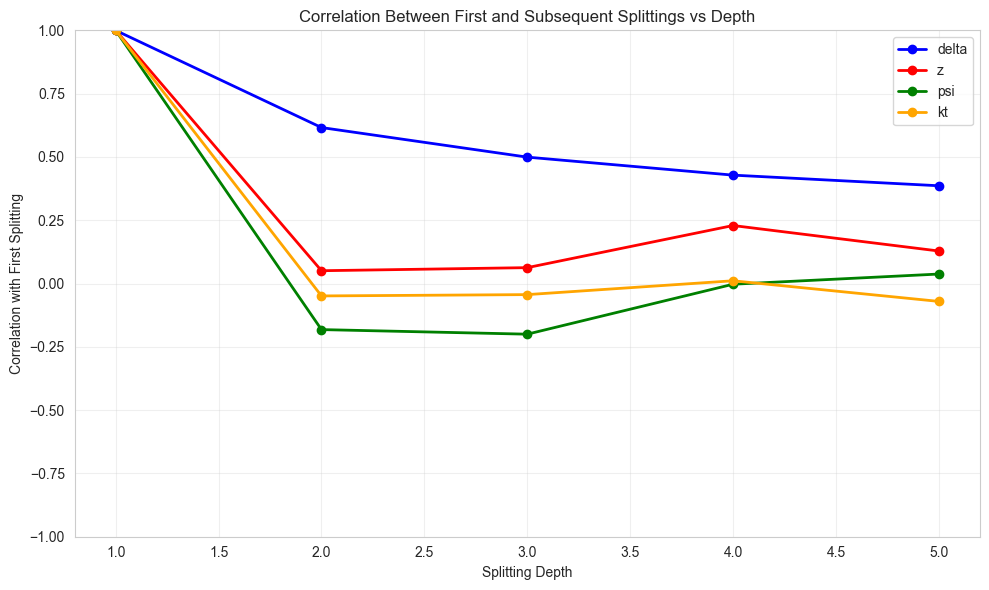


Correlation with first splitting by depth:
Depth  delta    z        psi      kt      
------------------------------------------------------------
1        1.000   1.000   1.000   1.000
2        0.616   0.051  -0.182  -0.049
3        0.499   0.063  -0.200  -0.044
4        0.428   0.229  -0.003   0.011
5        0.386   0.129   0.038  -0.070


In [12]:
# Analyze how correlations change with splitting depth
def analyze_splitting_depth_correlations(parquet_file, max_depth=5):
    """
    Analyze how variable correlations change as a function of splitting depth
    """
    df = pd.read_parquet(parquet_file)
    
    # Track correlations by depth
    depth_correlations = {}
    
    for depth in range(1, max_depth + 1):
        depth_correlations[depth] = {}
        
        # Collect data for jets with at least 'depth' splittings
        for idx, row in df.iterrows():
            lunds = row['lunds']
            
            if len(lunds) >= depth:
                # Compare splitting at depth 0 with splitting at specified depth
                first_split = lunds[0]
                depth_split = lunds[depth - 1]
                
                for var in ['delta', 'z', 'psi', 'kt']:
                    if var in first_split and var in depth_split:
                        if var not in depth_correlations[depth]:
                            depth_correlations[depth][var] = {'first': [], 'depth': []}
                        
                        depth_correlations[depth][var]['first'].append(first_split[var])
                        depth_correlations[depth][var]['depth'].append(depth_split[var])
    
    # Calculate correlation coefficients
    depth_results = {}
    for depth in range(1, max_depth + 1):
        depth_results[depth] = {}
        for var in ['delta', 'z', 'psi', 'kt']:
            if var in depth_correlations[depth] and len(depth_correlations[depth][var]['first']) > 1:
                first_vals = np.array(depth_correlations[depth][var]['first'])
                depth_vals = np.array(depth_correlations[depth][var]['depth'])
                
                # Remove infinite and NaN values
                mask = np.isfinite(first_vals) & np.isfinite(depth_vals)
                if np.sum(mask) > 1:
                    corr_coef = np.corrcoef(first_vals[mask], depth_vals[mask])[0, 1]
                    depth_results[depth][var] = {
                        'correlation': corr_coef,
                        'n_pairs': np.sum(mask)
                    }
    
    return depth_results

# Analyze depth correlations
depth_results = analyze_splitting_depth_correlations(parquet_file)

# Plot correlation vs depth
fig, ax = plt.subplots(figsize=(10, 6))

variables = ['delta', 'z', 'psi', 'kt']
colors = ['blue', 'red', 'green', 'orange']

for i, var in enumerate(variables):
    depths = []
    correlations = []
    
    for depth in depth_results:
        if var in depth_results[depth]:
            depths.append(depth)
            correlations.append(depth_results[depth][var]['correlation'])
    
    if depths:
        ax.plot(depths, correlations, 'o-', color=colors[i], label=var, linewidth=2, markersize=6)

ax.set_xlabel('Splitting Depth')
ax.set_ylabel('Correlation with First Splitting')
ax.set_title('Correlation Between First and Subsequent Splittings vs Depth')
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_ylim(-1, 1)

plt.tight_layout()
plt.savefig('splitting_depth_correlations.png', dpi=300, bbox_inches='tight')
print("Splitting depth correlations plot saved to: splitting_depth_correlations.png")
plt.show()

# Print numerical results
print("\nCorrelation with first splitting by depth:")
print("=" * 60)
print(f"{'Depth':<6} {'delta':<8} {'z':<8} {'psi':<8} {'kt':<8}")
print("-" * 60)
for depth in sorted(depth_results.keys()):
    line = f"{depth:<6}"
    for var in variables:
        if var in depth_results[depth]:
            corr = depth_results[depth][var]['correlation']
            line += f"{corr:8.3f}"
        else:
            line += f"{'---':<8}"
    print(line)